# Analytics Prototype (Elephant Hunter v 0.2)

We want to build a flexible analytics suite which can analyze and predict anomalous market motion, and capitalize on it. The end goal is to feed a trained machine learning system tick data, and have it, using historical data, predict the outcomes and their expected payoffs, by ranking the set of possible actions it will provide instructions to conduct automated trading. As a first step, we first want to analyze the behavior of the S&P 500 index in the opening hour of the market 9:30 - 10:30 on Mondays. To do this we will use Python to aggregate the data and then construct a number of descriptive statistics.

These import statements include the pandas package, which is perfectly suited for data analysis. Datetime to handle the date and time information of the tick data, and matplotlib so that graphs are visible within the notebook.

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file = open("dates.txt","r")

for line in file:
    fields = line.split(";")
    
file.close()

fields = fields[:-1]

In [3]:
def mlt_to_dt(matlab_datenum):
    python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return python_datetime

fields = [mlt_to_dt(float(p)) for p in fields]

In [4]:
file = open("ES.txt","r")

for line in file:
    fields1 = line.split(",")
    
file.close()

In [5]:
fields1=fields1[:-1]
fields1=[float(i) for i in fields1]

In [6]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015-11-14', end='2017-11-14').to_pydatetime()

df=pd.DataFrame(fields1,index=fields,columns=['ES_price'])
df.index = df.index.round('1min')
df=df[(df.index.dayofweek<5) & (df.index.hour<16) & (~df.index.isin(holidays))]

In [7]:
df['price_change'] = df['ES_price'] - df['ES_price'].shift(+1)

In [8]:
df['2nd'] = df['price_change'] - df['price_change'].shift(+1)

In [9]:
df['Volatility'] = df['ES_price'].rolling(window=30,center=False).std()

In [10]:
df['15min_max'] = df['ES_price'].rolling(window=15,center=False).max()

In [11]:
df['15min_min'] = df['ES_price'].rolling(window=15,center=False).min()

In [12]:
df['max_min_spread'] = df['15min_max'] - df['15min_min']

In [13]:
df['SMA'] = df['ES_price'].rolling(window=30,center=False).mean()

In [14]:
df['Lower_Bollinger'] = df['SMA'] - 2*df['Volatility']
df['Upper_Bollinger'] = df['SMA'] + 2*df['Volatility']

In [15]:
closing_prices=df.groupby(df.index.date).last()['ES_price']
df['close'] = [closing_prices[k.date()] for k in df.index]
shift_closing_prices=closing_prices.shift(1)
df['prev_close']=[shift_closing_prices[k.date()] for k in df.index]

In [16]:
df['up_or_down'] = df['close'] - df['prev_close']

In [17]:
df['abs_change'] = df['price_change'].apply(lambda x: abs(x))

In [18]:
change = df['price_change'].tolist()

In [19]:
Trending = [0] * len(change)
for i in range(2,len(change)):
    if((change[i] > 0) & (change[i-1] > 0)):
        Trending[i] = Trending[i-1] + 1
    elif((change[i] < 0) & (change[i-1] < 0)):
        Trending[i] = Trending[i-1] - 1
    else:
        Trending[i] = 0
        
df['zero_trending'] = Trending

In [20]:
Trending = [0] * len(change)
for i in range(2,len(change)):
    if(change[i] > 0):
        Trending[i] = Trending[i-1] + 1
    elif(change[i] < 0):
        Trending[i] = Trending[i-1] - 1
    else:
        Trending[i] = 0

df['cum_trending'] = Trending        

In [21]:
df.describe()

,ES_price,price_change,2nd,Volatility,15min_max,15min_min,max_min_spread,SMA,Lower_Bollinger,Upper_Bollinger,close,prev_close,up_or_down,abs_change,zero_trending,cum_trending
count,492543.000000,492542.000000,4.925410e+05,492514.000000,492529.000000,492529.000000,492529.000000,492514.000000,492514.000000,492514.000000,492543.000000,491583.000000,491583.000000,492542.000000,492543.000000,492543.000000
mean,2214.545897,0.001241,-5.075720e-07,0.801401,2215.463076,2213.612650,1.850426,2214.542592,2212.939789,2216.145395,2215.419939,2214.726718,1.105610,0.313628,0.004018,-0.002851
std,201.776074,0.556328,8.101877e-01,0.862714,201.463312,202.076868,1.800865,201.764597,202.309904,201.232607,201.772376,201.307622,14.368258,0.459500,0.747598,1.519725
min,1767.500000,-108.000000,-1.087500e+02,0.000000,1772.250000,1767.500000,0.000000,1770.900000,1762.681138,1773.846547,1787.250000,1787.250000,-77.250000,0.000000,-11.000000,-20.000000
25%,2047.000000,-0.250000,-2.500000e-01,0.356487,2048.000000,2046.250000,0.750000,2047.091667,2045.612636,2048.656685,2048.250000,2048.250000,-4.500000,0.000000,0.000000,-1.000000
50%,2165.750000,0.000000,0.000000e+00,0.573856,2166.500000,2165.250000,1.250000,2165.783333,2164.828820,2166.855505,2166.500000,2166.500000,1.000000,0.250000,0.000000,0.000000
75%,2390.000000,0.250000,2.500000e-01,0.975306,2390.500000,2389.750000,2.250000,2390.083333,2389.213391,2391.007434,2391.750000,2391.750000,8.250000,0.500000,0.000000,1.000000
max,2593.500000,25.750000,1.080000e+02,55.327944,2593.500000,2592.750000,112.250000,2592.933333,2592.519493,2594.299881,2591.500000,2591.500000,47.250000,108.000000,12.000000,19.000000


In [27]:
df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31)]['price_change'].describe()

count    103.000000
mean       0.160194
std        0.923452
min       -2.750000
25%       -0.500000
50%        0.250000
75%        0.750000
max        2.250000
Name: price_change, dtype: float64

In [86]:
df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==32)&((df.price_change.shift(1) < 1.08)&(df.price_change.shift(1) > -0.76))]['abs_change'].describe()

count    77.000000
mean      0.509740
std       0.426201
min       0.000000
25%       0.250000
50%       0.500000
75%       0.750000
max       2.000000
Name: abs_change, dtype: float64

In [111]:
minimums = []
maximums = []
mean_returns = []
std_dev = []
#lower_quartile = []
#upper_quartile = []
time_window=pd.date_range("09:32", "10:30", freq="1min").time
for i in range(1,60): 
    if(i < 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08)  & (df.up_or_down > 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0) ]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.25))
        i+=1
    elif(i >= 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.25))
        i+=1


df_930_1030_up_up=pd.DataFrame(minimums,index=time_window,columns=['min'])
df_930_1030_up_up['max'] = maximums
df_930_1030_up_up['mean'] = mean_returns
df_930_1030_up_up['std_dev'] = std_dev
df_930_1030_up_up['cumulative_return'] = df_930_1030_up_up['mean'].cumsum(axis = 0)
df_930_1030_up_up['max_min_spread'] = df_930_1030_up_up['max'] - df_930_1030_up_up['min']

In [112]:
minimums = []
maximums = []
mean_returns = []
std_dev = []
#lower_quartile = []
#upper_quartile = []
time_window=pd.date_range("09:32", "10:30", freq="1min").time
for i in range(1,60): 
    if(i < 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down < 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08)  & (df.up_or_down < 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down < 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down < 0) ]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.25))
        i+=1
    elif(i >= 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down < 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down < 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down < 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down < 0)]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.25))
        i+=1


df_930_1030_up_down=pd.DataFrame(minimums,index=time_window,columns=['min'])
df_930_1030_up_down['max'] = maximums
df_930_1030_up_down['mean'] = mean_returns
df_930_1030_up_down['std_dev'] = std_dev
df_930_1030_up_down['cumulative_return'] = df_930_1030_up_down['mean'].cumsum(axis = 0)
df_930_1030_up_down['max_min_spread'] = df_930_1030_up_down['max'] - df_930_1030_up_down['min']

In [90]:
minimums = []
maximums = []
mean_returns = []
std_dev = []
#lower_quartile = []
#upper_quartile = []
time_window=pd.date_range("09:32", "10:30", freq="1min").time
for i in range(1,60): 
    if(i < 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76))]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76))]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76))]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76)) ]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.25))
        i+=1
    elif(i >= 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76))]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76))]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76))]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & ((df.price_change.shift(i) < 1.08)&(df.price_change.shift(i) > -0.76))]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.25))
        i+=1





In [91]:
df_930_1030_mid=pd.DataFrame(minimums,index=time_window,columns=['min'])
df_930_1030_mid['max'] = maximums
df_930_1030_mid['mean'] = mean_returns
df_930_1030_mid['std_dev'] = std_dev
df_930_1030_mid['cumulative_return'] = df_930_1030_mid['mean'].cumsum(axis = 0)
df_930_1030_mid['max_min_spread'] = df_930_1030_mid['max'] - df_930_1030_mid['min']

In [92]:
minimums = []
maximums = []
mean_returns = []
std_dev = []
#lower_quartile = []
#upper_quartile = []
time_window=pd.date_range("09:32", "10:30", freq="1min").time
for i in range(1,60): 
    if(i < 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76) ]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.25))
        i+=1
    elif(i >= 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76)]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.25))
        i+=1






In [93]:
df_930_1030_down=pd.DataFrame(minimums,index=time_window,columns=['min'])
df_930_1030_down['max'] = maximums
df_930_1030_down['mean'] = mean_returns
df_930_1030_down['std_dev'] = std_dev
df_930_1030_down['cumulative_return'] = df_930_1030_down['mean'].cumsum(axis = 0)
df_930_1030_down['max_min_spread'] = df_930_1030_down['max'] - df_930_1030_down['min']

In [94]:
df_temp = df_930_1030_mid['mean'].to_frame()

In [95]:
df_temp['up'] = df_930_1030_up['mean']
df_temp['down'] = df_930_1030_down['mean']

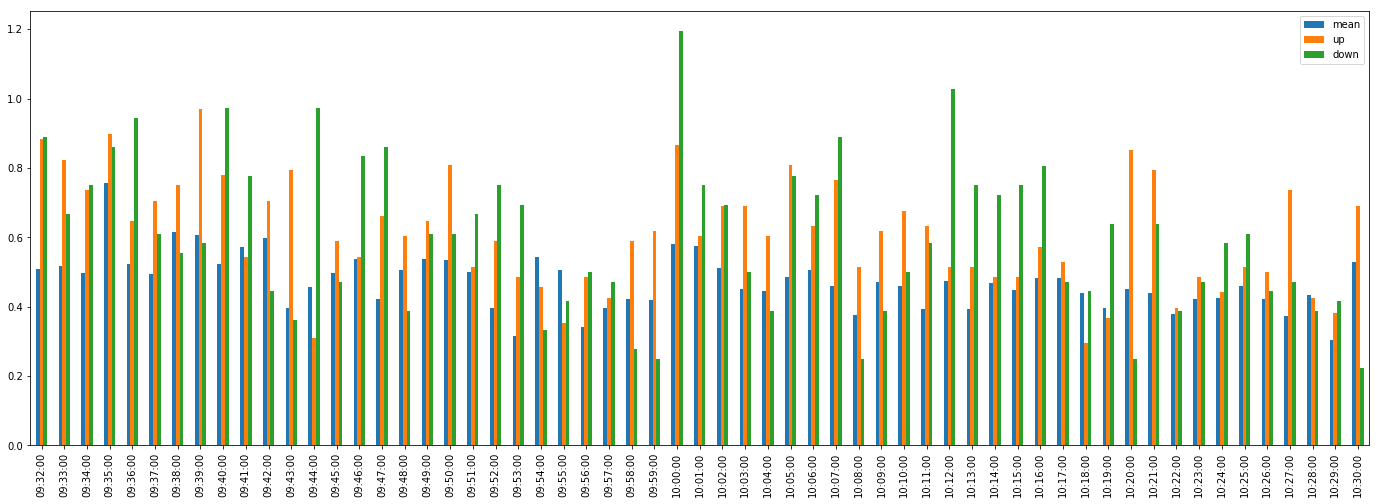

In [96]:
df_temp.plot.bar(figsize=(24,8));

In [101]:
df_temp['up_pct'] = (df_temp['up'] - df_temp['mean']) / (df_temp['mean'])

In [102]:
df_temp['down_pct'] = (df_temp['down'] - df_temp['mean']) / (df_temp['mean'])

In [103]:
df_temp2 = df_temp['up_pct'].to_frame()

In [104]:
df_temp2['down_pct'] = df_temp['down_pct']

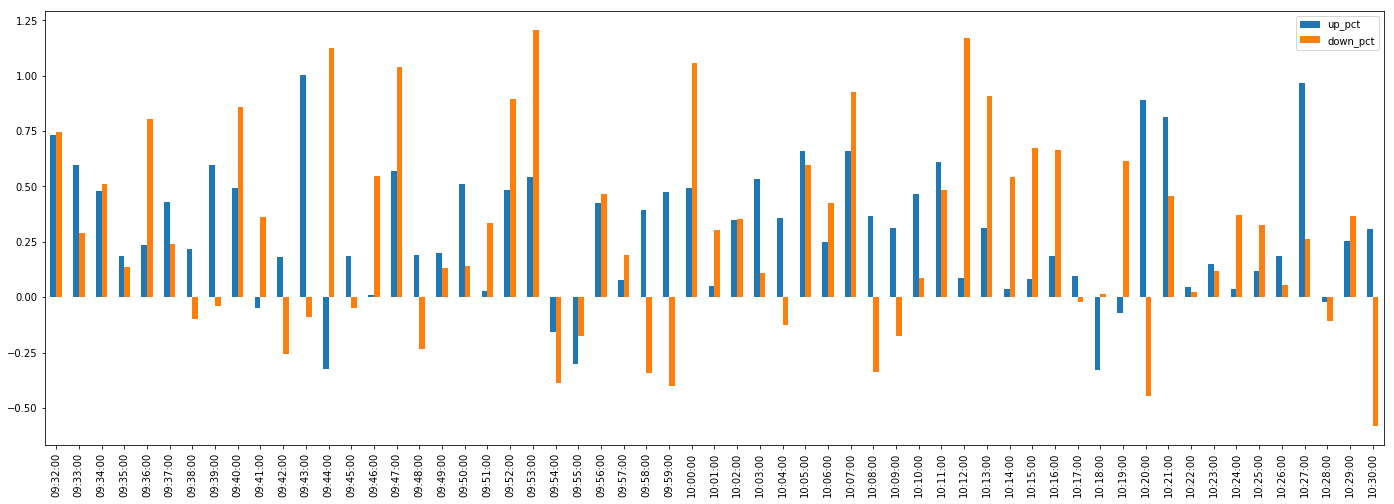

In [105]:
df_temp2.plot.bar(figsize=(24,8));

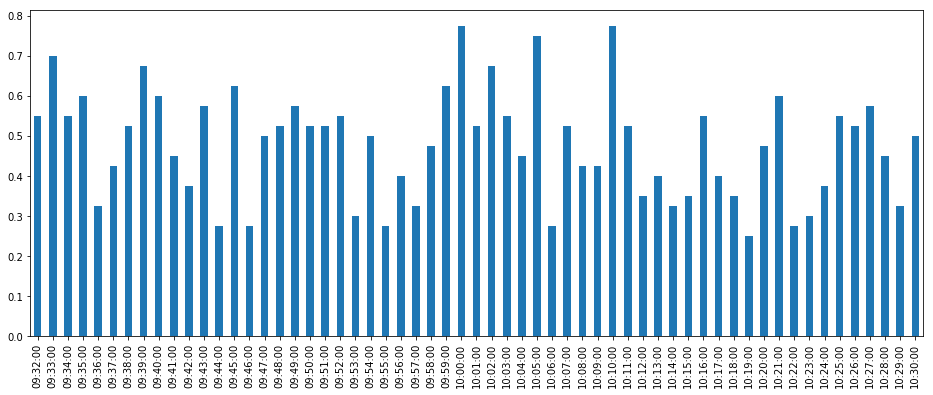

In [108]:
df_930_1030_up_up['mean'].plot(kind='bar',figsize=(16,6))

In [113]:
df_temp = df_930_1030_up_up['mean'].to_frame()
df_temp['down'] = df_930_1030_up_down['mean']

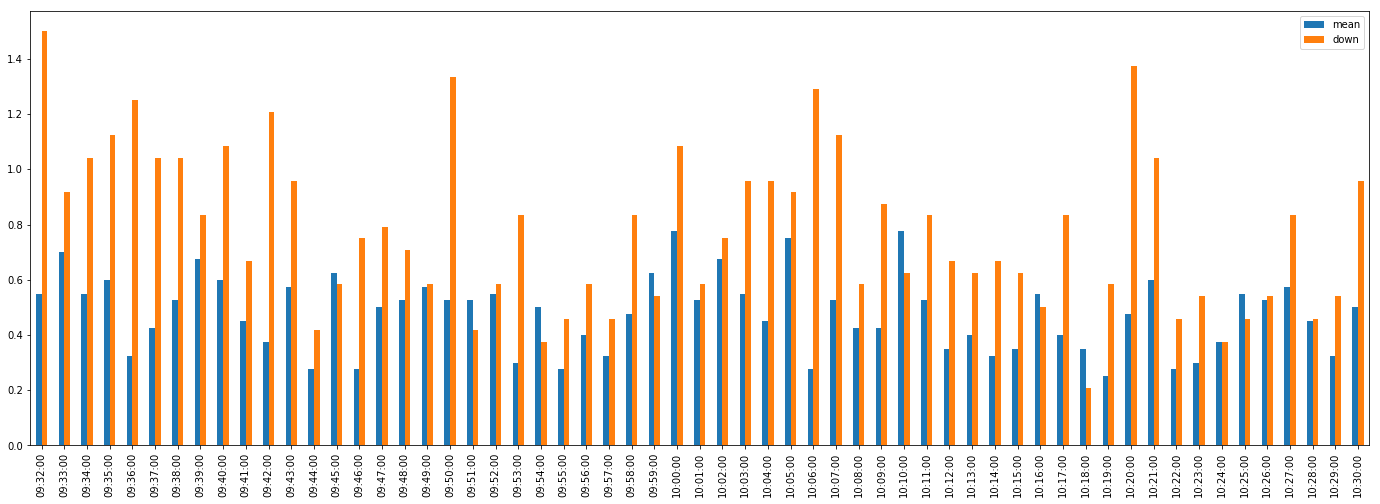

In [115]:
df_temp.plot.bar(figsize=(24,8));

In [117]:
minimums = []
maximums = []
mean_returns = []
std_dev = []
#lower_quartile = []
#upper_quartile = []
time_window=pd.date_range("09:32", "10:30", freq="1min").time
for i in range(1,60): 
    if(i < 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down > 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76)  & (df.up_or_down > 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down > 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= - 0.76) & (df.up_or_down > 0) ]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.25))
        i+=1
    elif(i >= 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <=-0.76) & (df.up_or_down > 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <=-0.76) & (df.up_or_down > 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down > 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down > 0)]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.25))
        i+=1


df_930_1030_down_up=pd.DataFrame(minimums,index=time_window,columns=['min'])
df_930_1030_down_up['max'] = maximums
df_930_1030_down_up['mean'] = mean_returns
df_930_1030_down_up['std_dev'] = std_dev
df_930_1030_down_up['cumulative_return'] = df_930_1030_down_up['mean'].cumsum(axis = 0)
df_930_1030_down_up['max_min_spread'] = df_930_1030_down_up['max'] - df_930_1030_down_up['min']

In [118]:
minimums = []
maximums = []
mean_returns = []
std_dev = []
#lower_quartile = []
#upper_quartile = []
time_window=pd.date_range("09:32", "10:30", freq="1min").time
for i in range(1,60): 
    if(i < 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down < 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76)  & (df.up_or_down < 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down < 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) <= - 0.76) & (df.up_or_down < 0) ]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 1.08) & (df.up_or_down > 0)]['abs_change'].quantile(.25))
        i+=1
    elif(i >= 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <=-0.76) & (df.up_or_down < 0)]['abs_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <=-0.76) & (df.up_or_down < 0)]['abs_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down < 0)]['abs_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) <= -0.76) & (df.up_or_down < 0)]['abs_change'].std())
        #upper_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.75))
        #lower_quartile.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75) & (df.up_or_down > 0)]['price_change'].quantile(.25))
        i+=1


df_930_1030_down_down=pd.DataFrame(minimums,index=time_window,columns=['min'])
df_930_1030_down_down['max'] = maximums
df_930_1030_down_down['mean'] = mean_returns
df_930_1030_down_down['std_dev'] = std_dev
df_930_1030_down_down['cumulative_return'] = df_930_1030_down_down['mean'].cumsum(axis = 0)
df_930_1030_down_down['max_min_spread'] = df_930_1030_down_down['max'] - df_930_1030_down_down['min']

In [119]:
df_temp = df_930_1030_down_up['mean'].to_frame()
df_temp['down'] = df_930_1030_down_down['mean']

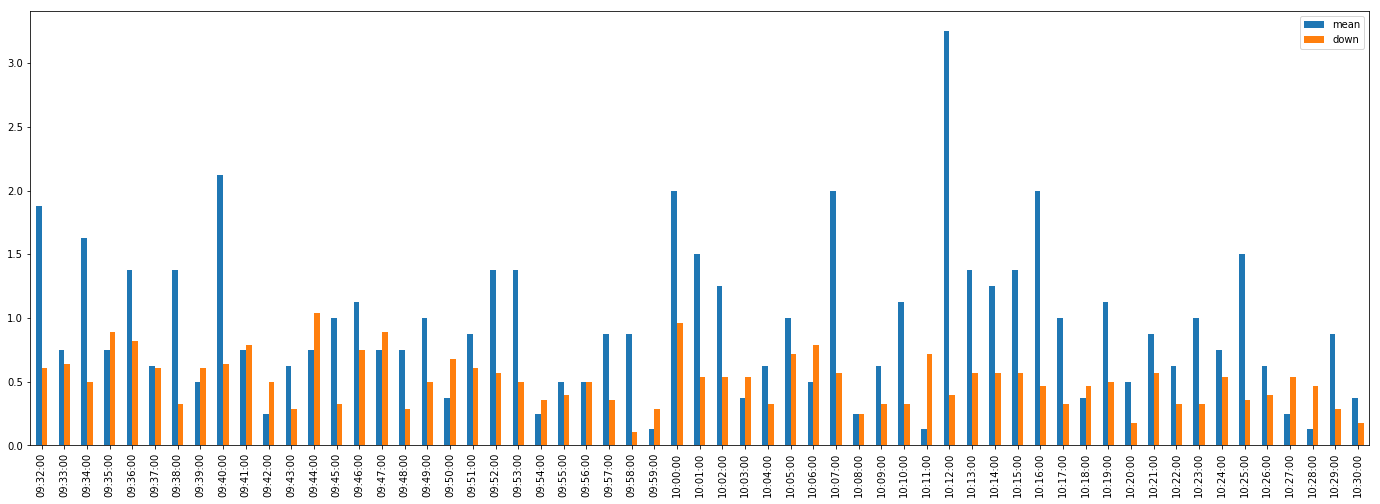

In [120]:
df_temp.plot.bar(figsize=(24,8));

In [129]:
df_temp = df_930_1030_up_up['mean'].to_frame()
df_temp['down'] = df_930_1030_down_down['mean']

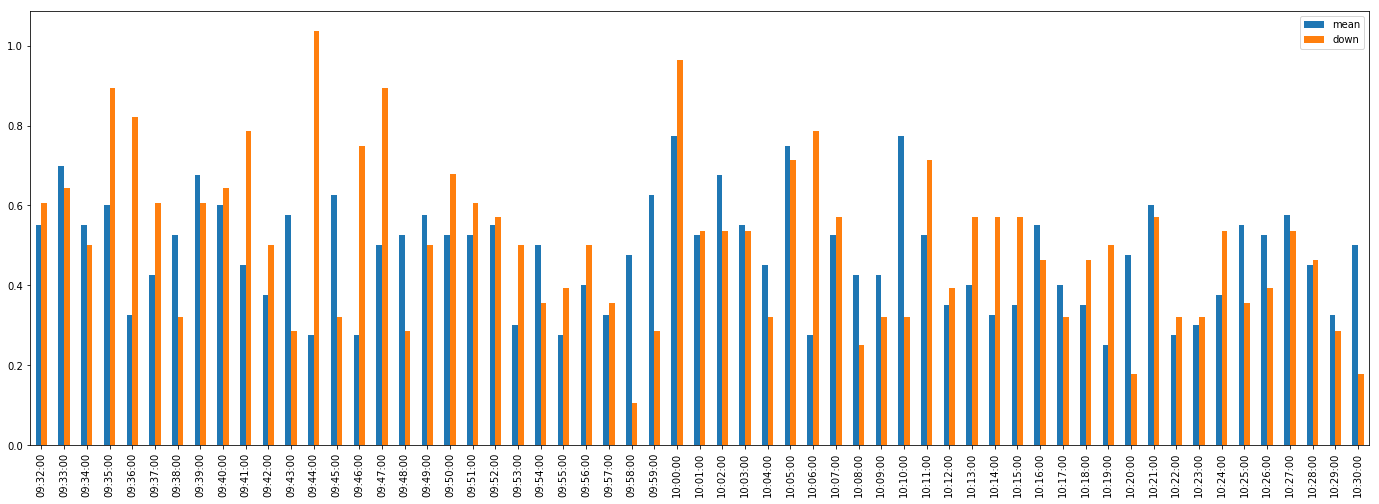

In [130]:
df_temp.plot.bar(figsize=(24,8));

In [135]:
df_temp = df_930_1030_down_up['mean'].to_frame()
df_temp['up'] = df_930_1030_up_up['mean']

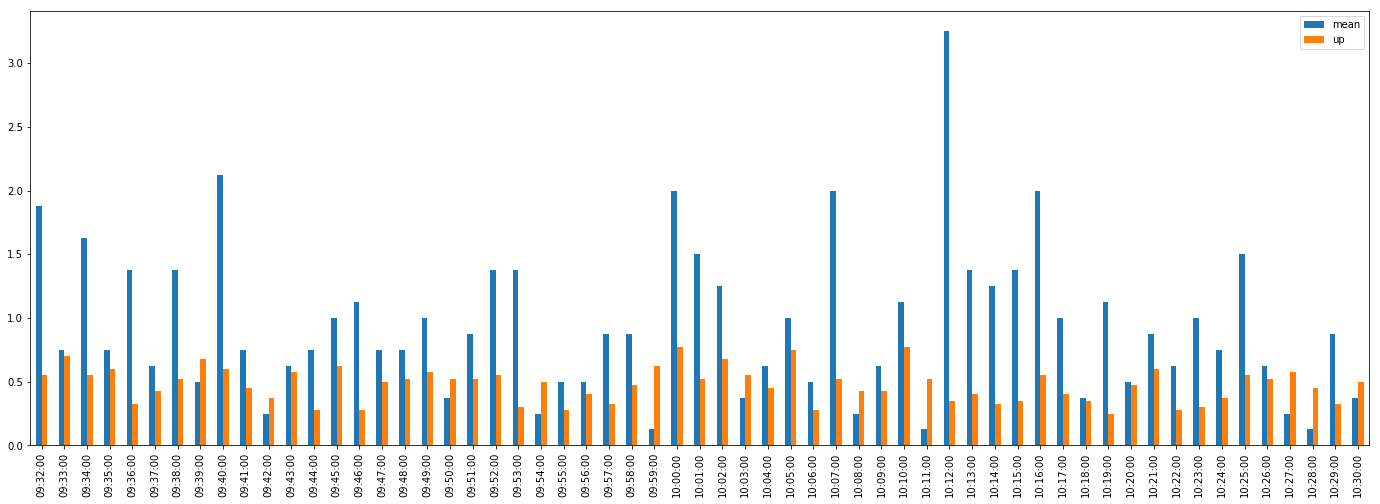

In [136]:
df_temp.plot.bar(figsize=(24,8));

In [137]:
df_temp = df_930_1030_down_down['mean'].to_frame()
df_temp['up'] = df_930_1030_up_down['mean']

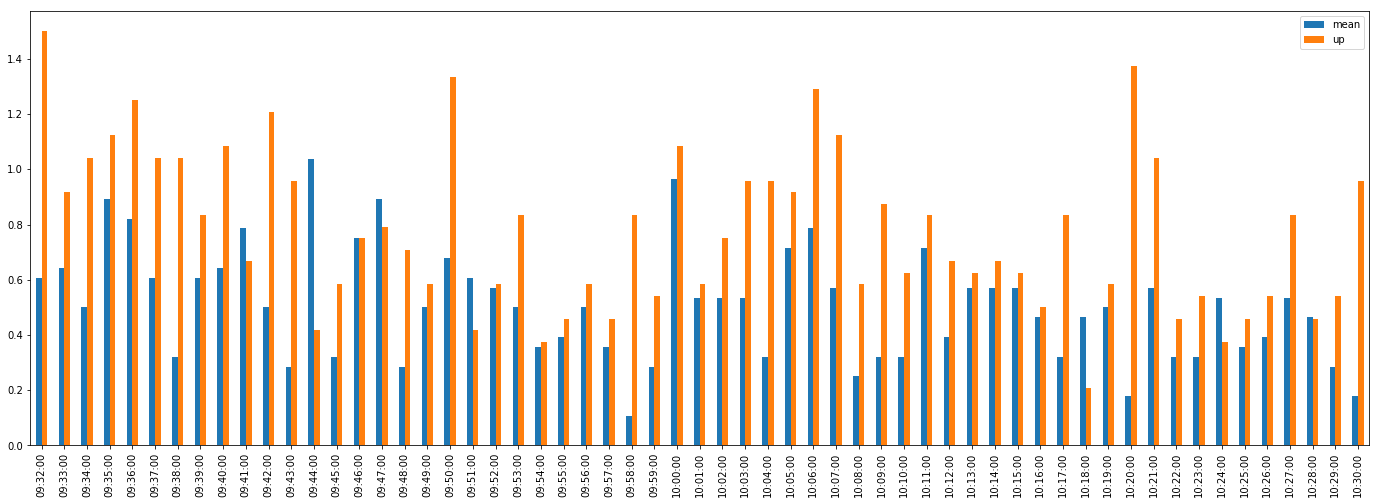

In [138]:
df_temp.plot.bar(figsize=(24,8));